# 半截图片与完整图片的匹配

## 事前准备

- [x] 半截图片的准备
- [x] 半截图片缩略图的提取(带python脚本)
- [x] 缩略图增强图片的准备

## 匹配步骤

- [x] 半截图片与完整图片对比
- [ ] 半截图片中花屏和错误图片的识别

### 半截图片缩略图的提取

In [ ]:
import os

jpg_tag_id_name_map = {
    b'\xff\xd8' : 'SOI',
    b'\xff\xc0' : 'SOF0',
    b'\xff\xc2' : 'SOF2',
    b'\xff\xc4' : 'DHT',
    b'\xff\xdb' : 'DQT',
    b'\xff\xdd' : 'DRI',
    b'\xff\xfe' : 'COM',
    b'\xff\xda' : 'SOS',
    b'\xff\xd9' : 'EOI',
}

jpg_tag_name_id_map = {v:k for k,v in jpg_tag_id_name_map.items()}

def get_tag_name(tag_id : bytes):
    
    if tag_id in jpg_tag_id_name_map:
        return jpg_tag_id_name_map[tag_id]
    
    if len(tag_id) != 2 or tag_id[0] != 0xff:
        return ''
    
    if tag_id[1] in range(0xd0, 0xd7 + 1):
        return 'RST' + str(tag_id[1] & 0x0f)
    if tag_id[1] in range(0xe0, 0xef + 1):
        return 'APP' + str(tag_id[1] & 0x0f)

    return 'Unknow: ' + tag_id.hex().upper()

def get_tag_id(tag_name : str):
    tag_name = tag_name.upper()
    if tag_name in jpg_tag_name_id_map:
        return jpg_tag_name_id_map[tag_name]
    
    if len(tag_name) < 4 or int(tag_name[3:]) > 0xf:
        return b''
    
    if tag_name[:3] == 'RST':
        return b'\xff' + (0xd0 | int(tag_name[3:])).to_bytes(1, 'big')
    if tag_name[:3] == 'APP':
        return b'\xff' + (0xe0 | int(tag_name[3:])).to_bytes(1, 'big')

class Jpeg:
    def __init__(self, data : bytes()):
        self.data = data
        self.soi_pos = -1
        self.sof0_pos = -1
        self.dht_pos = -1
        self.dqt_pos = -1
        self.sos_pos = -1
        self.eoi_pos = -1
    
    def _get_tag(self, tag_pos):
        if tag_pos < 0 or tag_pos >= len(self.data):
            return b''
        return self.data[tag_pos : tag_pos + 2]
    
    def _get_next_tag(self, tag_pos):
        if tag_pos == -1:
            return '', -1
        
        tag = self._get_tag(tag_pos)
        next_tag_pos = -1

        if tag == get_tag_id('EOI'):
            pass
        elif tag == get_tag_id('SOI'):
            next_tag_pos = tag_pos + 2
        elif tag == get_tag_id('SOS'):
            next_tag_pos = self.data.find(get_tag_id('EOI'), tag_pos)
        else:
            payload_len = int.from_bytes(self.data[tag_pos + 2 : tag_pos + 4], byteorder='big')
            next_tag_pos = tag_pos + 2 + payload_len
            
        return get_tag_name(self._get_tag(next_tag_pos)), next_tag_pos
    
    def _is_valid_jpeg(self):
        return (self.soi_pos >= 0 and
               self.sof0_pos >= 0 and
               self.dht_pos >= 0 and
               self.dqt_pos >= 0 and
               self.sos_pos >= 0 and
               self.eoi_pos >= 0)
            
    
    def analyse(self):
        self.soi_pos = self.data.find(get_tag_id('SOI'))
        tag_pos = self.soi_pos
        while(True):
            tag_name, tag_pos = self._get_next_tag(tag_pos)
            if tag_pos == -1:
                break
#             print(tag_name, hex(tag_pos))
            
            if tag_name == 'SOF0':
                self.sof0_pos = tag_pos
            elif tag_name == 'DHT':
                self.dht_pos = tag_pos
            elif tag_name == 'DQT':
                self.dqt_pos = tag_pos
            elif tag_name == 'SOS':
                self.sos_pos = tag_pos
            elif tag_name == 'EOI':
                self.eoi_pos = tag_pos
    
    def get_thumbnail(self):
        if not self._is_valid_jpeg:
            return None
        
        thumb_soi_pos = self.data.find(get_tag_id('SOI'), self.soi_pos + 1, self.eoi_pos)
        if thumb_soi_pos == -1:
            return None
        thumb_eoi_pos = -1
        tag_pos = thumb_soi_pos
        while(True):
            tag_name, tag_pos = self._get_next_tag(tag_pos)
            
            if tag_pos == -1 or tag_pos >= self.sos_pos or tag_name == '':
                break
            if tag_name == 'EOI':
                thumb_eoi_pos = tag_pos
                break
        
        if thumb_eoi_pos == -1:
            return None
        
        return self.data[thumb_soi_pos : thumb_eoi_pos + 2]

def extract_thumb(img_path, thumb_path):
    data = bytes()
    with open(img_path, 'rb') as f:
        data = f.read()

    jpeg = Jpeg(data)
    jpeg.analyse()
    thumb_data = jpeg.get_thumbnail()

    if thumb_data == None:
        pass
    else:
        with open(thumb_path, 'wb') as f:
            f.write(thumb_data)
        
thumb_out_dir = './data/thumb/'

for dir_path, dir_list, file_list in os.walk('./data/source/'):
    for file_name in file_list:
        img_path = os.path.join(dir_path, file_name)
        
        stem, ext = os.path.splitext(file_name)
        thumb_path = os.path.join(thumb_out_dir, stem + '-thumb' + ext)
        
        print(img_path)
        extract_thumb(img_path, thumb_path)
        

### 完整图片中黑边的处理

(480, 640, 3)
59 417 0 639


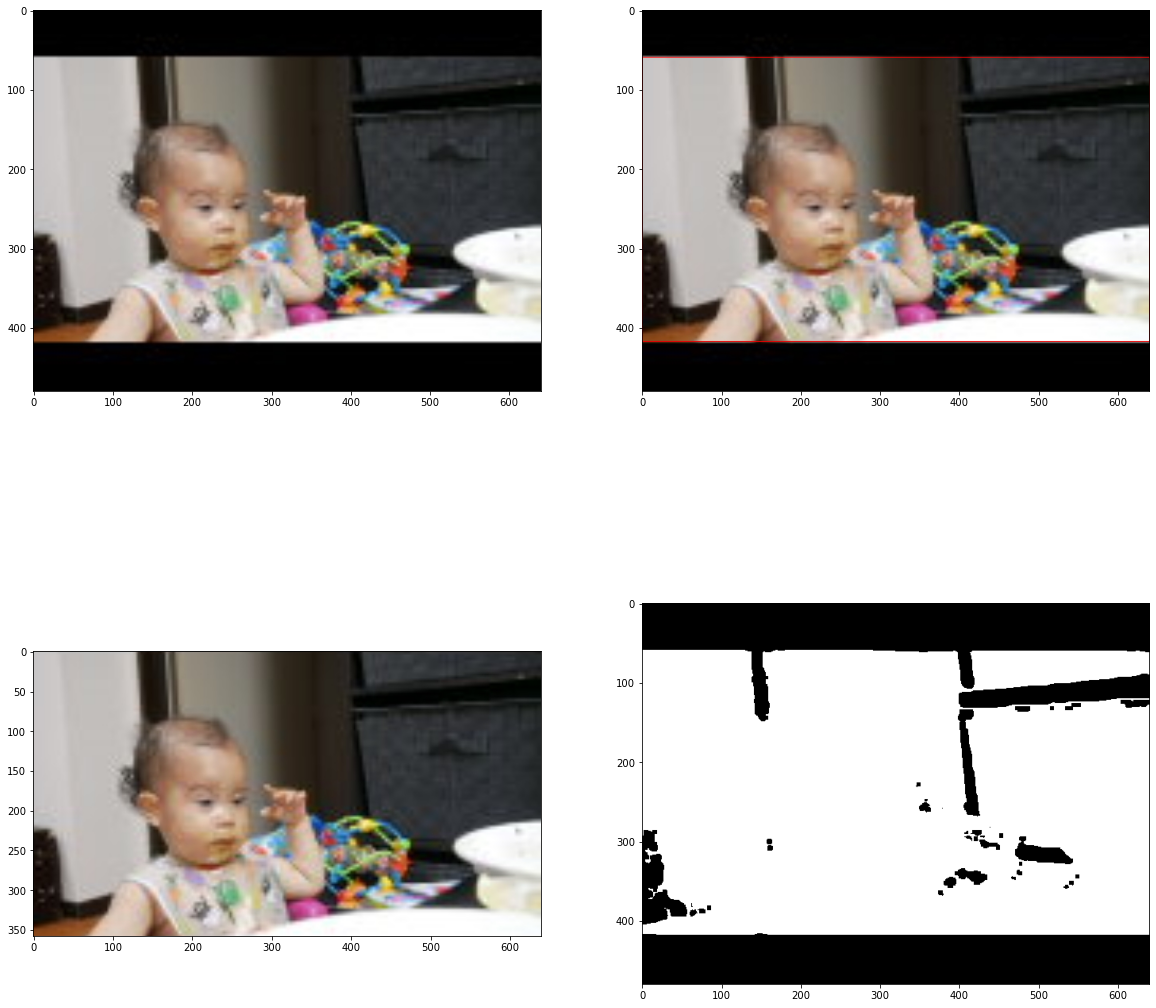

In [2]:
import cv2
import matplotlib.pyplot as plt
import imagehash
import os
import numpy as np
from PIL import Image

def cvt_color_to_plt(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.rc('figure', figsize=(20,20))

fig, axes = plt.subplots(2, 2)

def get_black_border(img):
    blur = cv2.erode(img, np.ones((5,5),np.uint8))
    hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
    binary = ~cv2.inRange(hls, (0,0,0), (255, 20, 255))
#     blur = cv2.medianBlur(img, 5)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     blur = cv2.erode(gray, np.ones((5,5),np.uint8))
    
#     thresh, binary = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
    
    axes[1,1].imshow(cvt_color_to_plt(binary))
    
    rows, cols = binary.shape
    
    up = down = left = right = 0
    
    for i in range(rows):
        if binary[i].sum() != 0:
            up = i
            break
    for i in range(rows)[::-1]:
        if binary[i].sum() != 0:
            down = i
            break
    for i in range(cols):
        if binary[:, i].sum() != 0:
            left = i
            break
    for i in range(cols)[::-1]:
        if binary[:, i].sum() != 0:
            right = i
            break
            
    return up, down, left, right
            
def crop_black_border(img):
    up, down, left, right = get_black_border(img)
    print(img.shape)
    print(up, down, left, right)

    return img[up:down, left:right]

img = cv2.imread('data/problem/black_border/0000795321_P1090460_repaired.JPG')
up, down, left, right = get_black_border(img)
print(img.shape)
print(up, down, left, right)

draw = cv2.rectangle(img.copy(), (left, up), (right, down), (0,0,255))

crop = img[up:down, left:right]

axes[0,0].imshow(cvt_color_to_plt(img))
axes[0,1].imshow(cvt_color_to_plt(draw))
axes[1,0].imshow(cvt_color_to_plt(crop))
# axes[1,1].imshow(cvt_color_to_plt(crop))

### 半截图片中花屏和错误图片的识别

C:\Users\Administrator\AppData\Local\Temp/ipykernel_33772/2820541356.py:40: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(pixel - up) + abs(pixel - up_left) + abs(pixel - up_right)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_33772/2820541356.py:39: RuntimeWarning: overflow encountered in ubyte_scalars
  similar = abs(pixel - right) + abs(pixel - down) + abs(pixel - down_right)


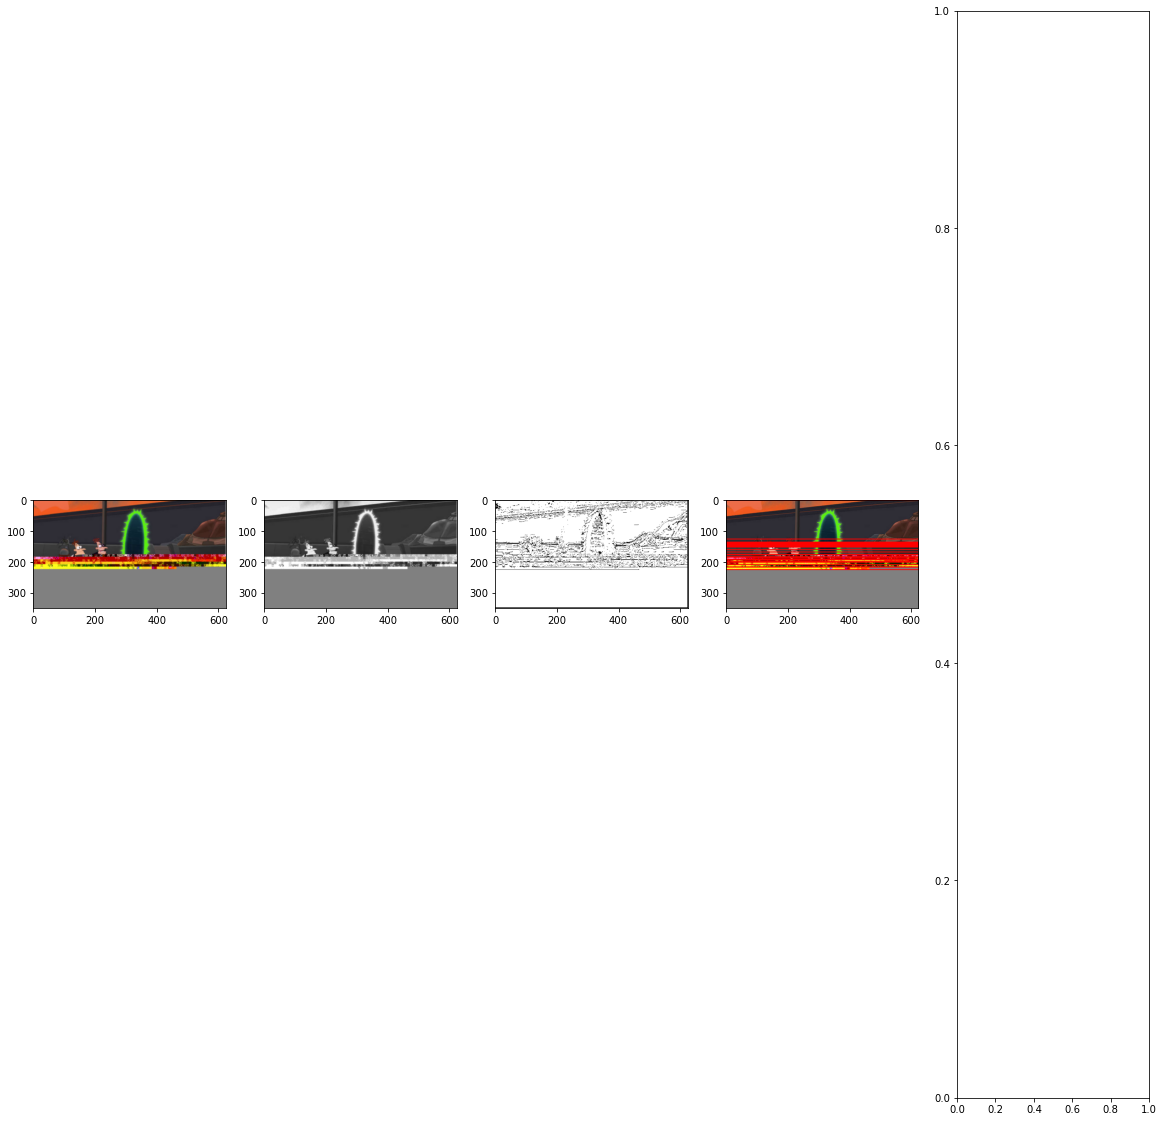

In [28]:
import cv2
import matplotlib.pyplot as plt
import imagehash
import os
import numpy as np
from PIL import Image

def cvt_color_to_plt(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_img_split_line(img_path, pixel_threhold=25, diff_threhold=50):
    img = cv2.imread(src_file_path)
#     blur = cv2.GaussianBlur(img, (5,5), 0)
    k = np.array([[1,1,1],[2,2,2],[2,2,2]])
    k = k / k.sum()
#     k = np.zeros((5,5))
#     k[2] = (1/5)
    blur = cv2.filter2D(img, -1, k)
#     b,g,r = cv2.split(blur)
    gray = blur.max(axis=2)
#     print(gray)
#     return
#     gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
#     gray = np.float32(gray)
    
    mask = np.zeros(gray.shape, dtype=np.uint8)
    
    for i, row in enumerate(gray[1:-1]):
        for j, pixel in enumerate(row[1:-1]):
            up = gray[i-1, j]
            up_left = gray[i-1, j-1]
            up_right = gray[i-1, j+1]
            down = gray[i+1, j]
            down_left = gray[i+1, j-1]
            down_right = gray[i+1, j-1]
            left = gray[i, j-1]
            right = gray[i, j+1]
            
            similar = abs(pixel - right) + abs(pixel - down) + abs(pixel - down_right)
            diff = abs(pixel - up) + abs(pixel - up_left) + abs(pixel - up_right)
#             if similar > 255 or diff > 255:
#                 print(similar, diff > 255)
            if (diff > pixel_threhold * 3) and (similar < pixel_threhold * 3):
                mask[i,j] = 0
            else:
                mask[i,j] = 255
        
        if (mask[i] == 0).sum() > mask.shape[1] * 0.2:
            cv2.line(img, (0, i), (mask.shape[1], i), (0, 0, 255), 2)
    
#     lines = cv2.HoughLines(~mask[1:],1,np.pi/180, int(mask.shape[1] * 0.2))
#     print(lines)
#     rho, theta = min(lines, key=lambda line: 999999999 if abs(line[0][1] - np.pi / 2) > 0.001 else line[0][0])[0]
#     print(rho, theta)
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     cv2.line(img,(x1,y1),(x2,y2),(0,0,255),4)
    
#     cut = img[:min(y1, y2)]
    
#     kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
#     ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
#     gx = cv2.filter2D(blur, -1, kx)
#     gy = cv2.filter2D(blur, -1, ky)
    
#     g = np.sqrt(gx ** 2 + gy ** 2)
#     g = np.abs(gx) + np.abs(gy)
#     sobel = cv2.Sobel(blur, -1, 1, 0, ksize = 3)
    
    plt.figure(figsize=(20,20))
    grid_size = (1, 5)
    p1 = plt.subplot2grid(grid_size, (0, 0))
    p2 = plt.subplot2grid(grid_size, (0, 1))
    p3 = plt.subplot2grid(grid_size, (0, 2))
    p4 = plt.subplot2grid(grid_size, (0, 3))
    p5 = plt.subplot2grid(grid_size, (0, 4))

    p1.imshow(cvt_color_to_plt(blur))
    p2.imshow(cvt_color_to_plt(np.uint8(gray)))
    p3.imshow(cvt_color_to_plt(np.uint8(mask)))
    p4.imshow(cvt_color_to_plt(img))
#     p5.imshow(cvt_color_to_plt(cut))

file_name = '0000585946_JPG_213110784'
src_file_path = './data/source/' + file_name + '.jpg'

get_img_split_line(src_file_path, 10)

plt.show()

### 半截图片与完整图片对比

0000586273_jpg_86880870400.jpg
(900, 900, 3)
0 899 0 899
proportion: 35.91%
20
26
proportion: 35.91%
28
30


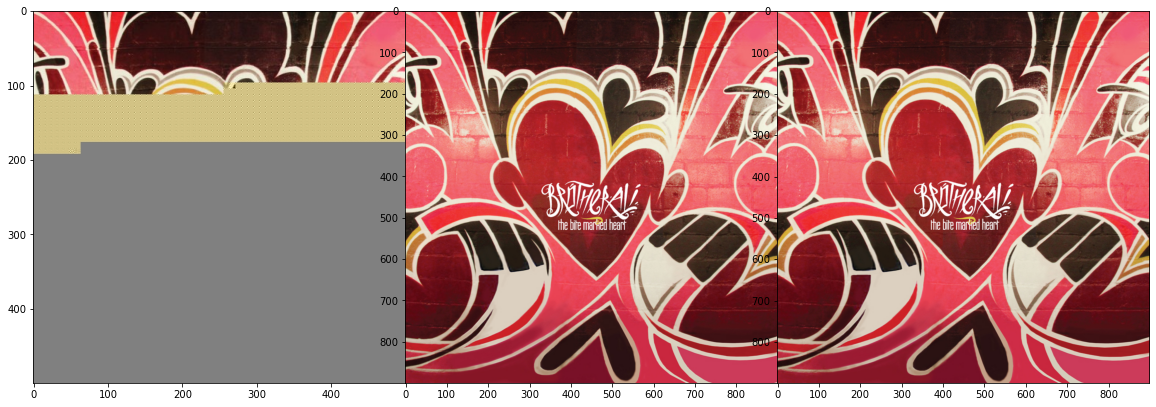

False
0000588508_ _cdc3a_2019-07-02_21889536.jpg
(480, 640, 3)
0 479 0 639
proportion: 72.84%
10
34
proportion: 72.76%
28
26


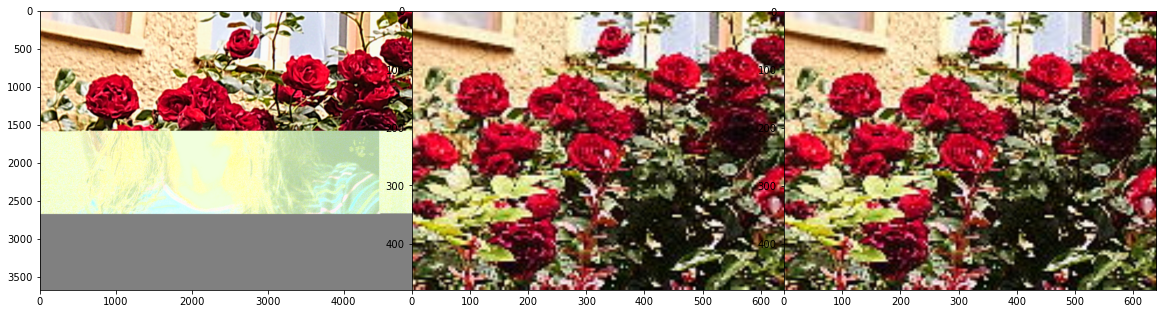

False
0000588702_sony ericsson_st25i_163607298048.jpg
(480, 640, 3)
0 479 0 639
proportion: 96.30%
8


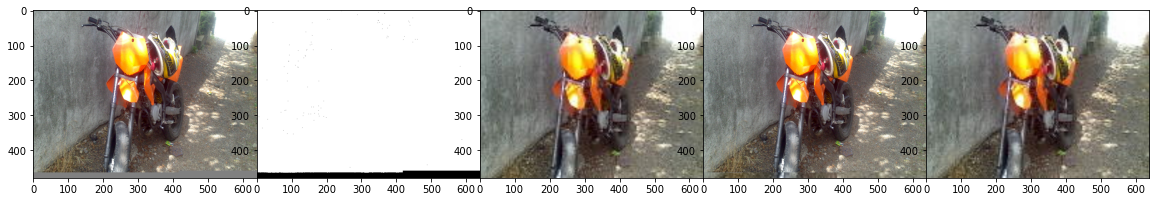

True
0000589617_dsc_1029.jpg
(640, 480, 3)
0 639 66 424
proportion: 99.46%
24
32
proportion: 99.38%
30
10


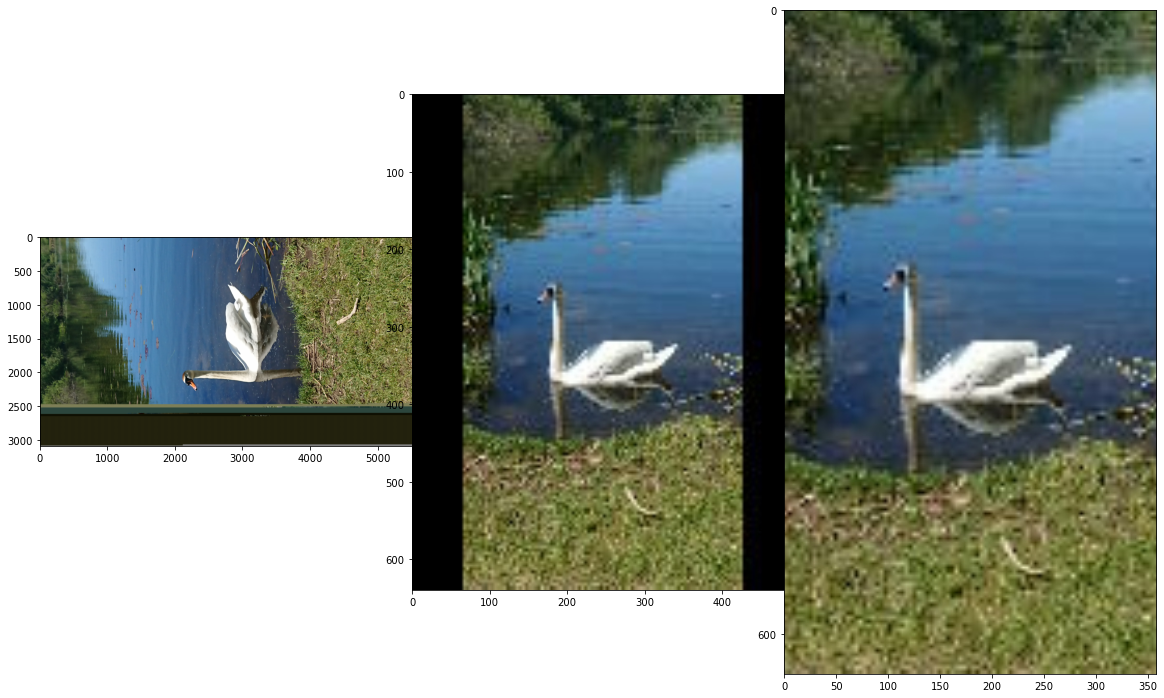

False
0000590222_2011-08-07_20-05-11_585.jpg
(960, 1280, 3)
0 959 0 1279
proportion: 97.51%
14
28
proportion: 97.50%
28
28


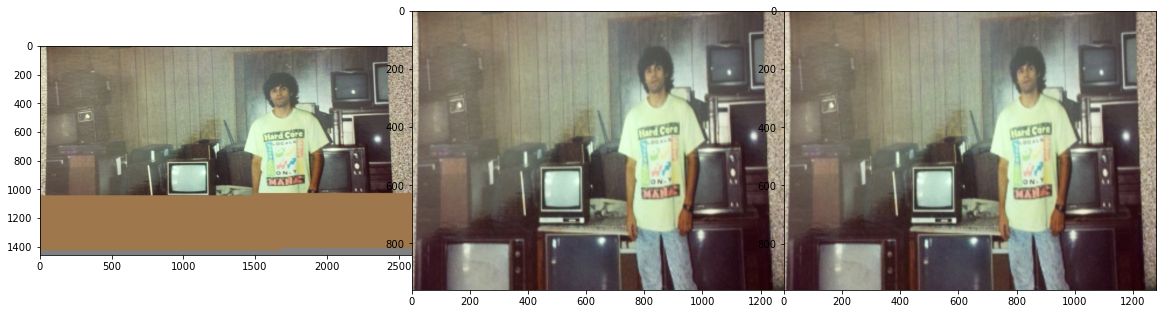

False
0000591178_img_20190514_085246.jpg
(576, 1024, 3)
0 575 0 1023
proportion: 93.39%
24
26
proportion: 93.40%
32
28


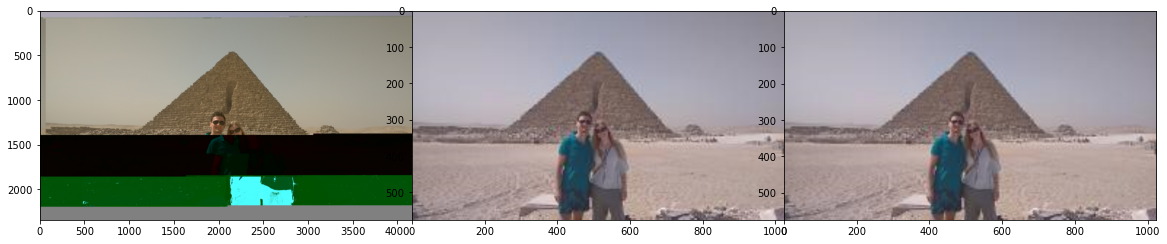

False
0000644864_20210722_161628[1].jpg
(384, 512, 3)
0 383 0 511
proportion: 100.00%
22
30
proportion: 100.00%
36
30


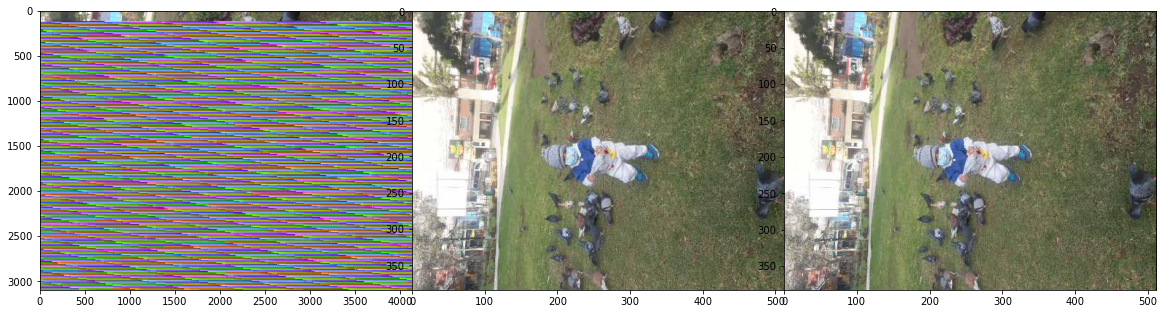

False
0000646850_2016-10-26_2427129856.jpg
(120, 640, 3)
0 119 0 639
proportion: 67.58%
10
32
proportion: 67.78%
30
24


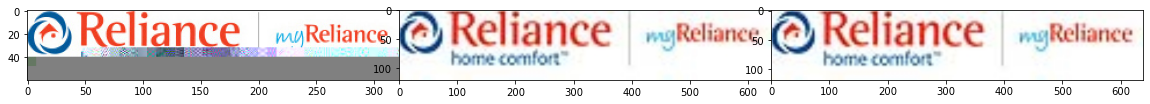

False
0000665349_dsc02208.jpg
(480, 640, 3)
0 479 0 639
proportion: 68.67%
12
28
proportion: 68.69%
32
32


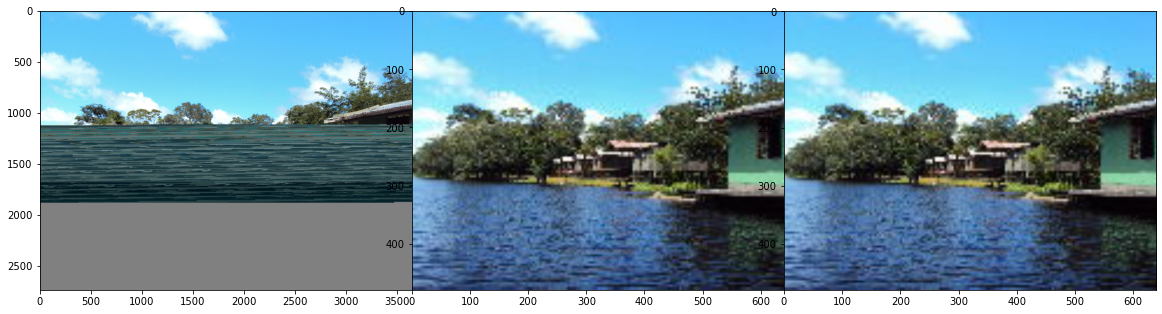

False
0000666814_canon_canon eos rebel t7i_2021-10-20_1079115776.jpg
(480, 640, 3)
0 479 0 639
proportion: 48.73%
16
22
proportion: 48.73%
32
34


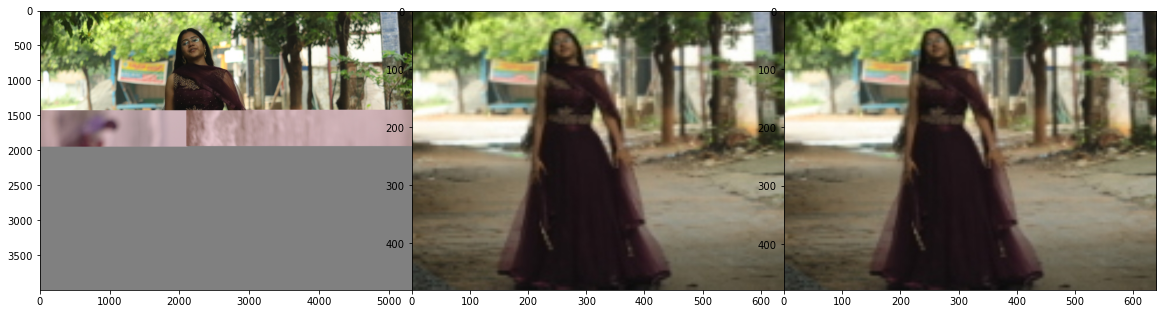

False
0000667057_samsung_sm-g977b_2020-02-15_35314225152.jpg
(2784, 7568, 3)
0 2783 0 7449
proportion: 100.00%
2


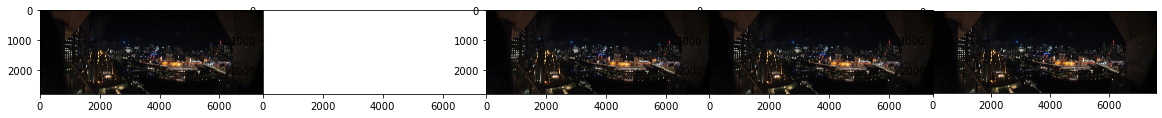

True
0000674814_.dsc_0005_horizon.jpg
(960, 1280, 3)
0 959 0 1279
proportion: 71.87%
22
34
proportion: 71.86%
30
40


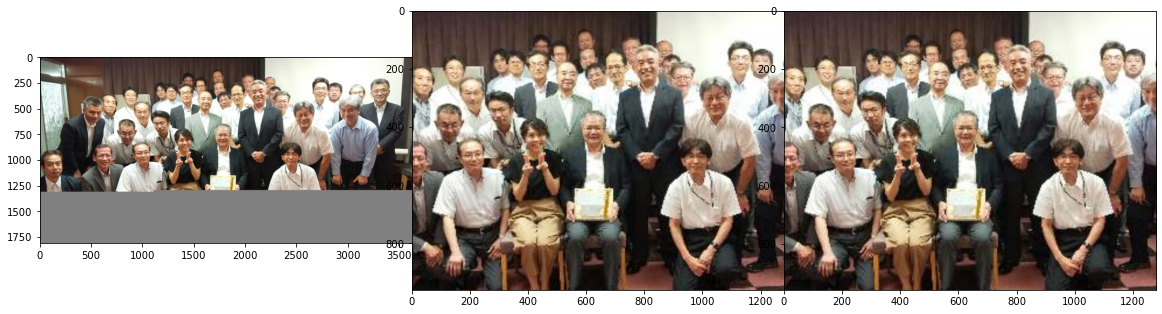

False
0000795155_dsc03284.jpg
(480, 640, 3)
0 479 0 639
proportion: 100.00%
10
32
proportion: 100.00%
38
34


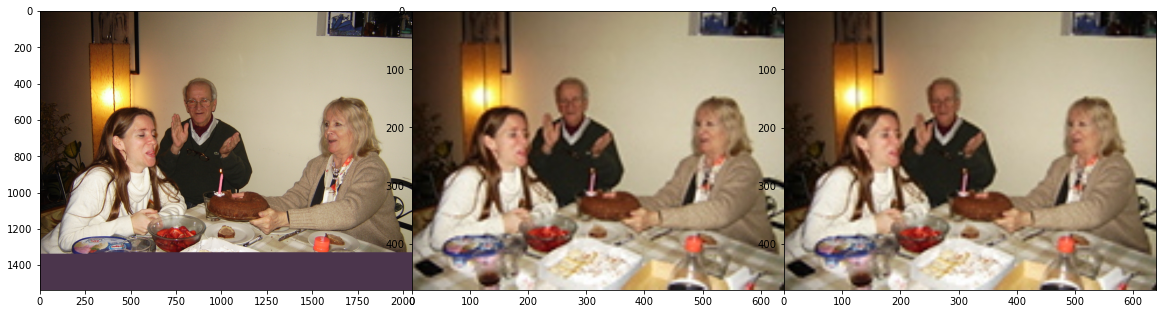

False


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imagehash
import os
import shutil
from PIL import Image

plt.rc('figure', figsize=(20,20))

def cvt_color_to_plt(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_white_proportion(mask):
    total = mask.shape[0] * mask.shape[1]
    return ((mask > 0).sum() / total) * 100

def Get_gray_mask(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(img_hsv, (0, 0, 127), (0, 0, 129))
    return mask

def Compare_half_img(half_img, crop_black_img, thumb_img):
    merge = np.empty(0)
    
    half_img_resize = cv2.resize(half_img, (crop_black_img.shape[1], crop_black_img.shape[0]))
    
    mask = ~Get_gray_mask(half_img_resize)
    gray_proportion = get_white_proportion(mask)
    print(f'proportion: {gray_proportion:.2f}%')

    compare_img = lambda h1, img: imagehash.phash(Image.fromarray(img)) - h1

    half_img_complete = cv2.copyTo(half_img_resize, mask)
    h1 = imagehash.phash(Image.fromarray(half_img_complete))


    crop_black_img_complete = cv2.copyTo(crop_black_img, mask)
    similarity = compare_img(h1, crop_black_img_complete)
    print(similarity)

    if similarity >= 10:
        crop_black_img = cv2.rotate(crop_black_img, cv2.ROTATE_180)
        crop_black_img_complete = cv2.copyTo(crop_black_img, mask)
        similarity = compare_img(h1, crop_black_img_complete)
        print(similarity)
    
    if similarity < 10:
        merge = half_img_complete + cv2.bitwise_and(crop_black_img, crop_black_img, mask = ~mask)
        
        grid_size = (1, 5)
        p1 = plt.subplot2grid(grid_size, (0, 0))
        p2 = plt.subplot2grid(grid_size, (0, 1))
        p3 = plt.subplot2grid(grid_size, (0, 2))
        p4 = plt.subplot2grid(grid_size, (0, 3))
        p5 = plt.subplot2grid(grid_size, (0, 4))

        p1.imshow(cvt_color_to_plt(half_img_resize))
        p2.imshow(cvt_color_to_plt(mask))
        p3.imshow(cvt_color_to_plt(crop_black_img))
        p4.imshow(cvt_color_to_plt(merge))
        p5.imshow(cvt_color_to_plt(thumb_img))
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
    return similarity, merge

def is_match(half_img_path, complete_img_path):
    try:
        half_img = cv2.imread(half_img_path, cv2.IMREAD_IGNORE_ORIENTATION | cv2.IMREAD_COLOR)
        complete_img = cv2.imread(complete_img_path)
    except:
        return False, None
    
    if half_img is None or complete_img is None:
        return False, None

    crop_black = crop_black_border(complete_img)
    
    similarity, merge = Compare_half_img(half_img, crop_black, complete_img)
    if similarity < 10:
        return True, merge
    similarity, merge = Compare_half_img(half_img, cv2.rotate(crop_black, cv2.ROTATE_90_CLOCKWISE), complete_img)
    if similarity < 10:
        return True, merge
    
    grid_size = (1, 3)
    p1 = plt.subplot2grid(grid_size, (0, 0))
    p2 = plt.subplot2grid(grid_size, (0, 1))
    p3 = plt.subplot2grid(grid_size, (0, 2))

    p1.imshow(cvt_color_to_plt(half_img))
    p2.imshow(cvt_color_to_plt(complete_img))
    p3.imshow(cvt_color_to_plt(crop_black))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    return False, merge



repaired_sufix = "_repaired.jpg"
merged_sufix = "_merged.jpg"
my_test_merge_sufix = "_test_merged.jpg"

out_dir = './data/out'
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.mkdir(out_dir)

for root, dirs, files in os.walk('./data/problem/should_similar'):
    for file in files:
        if repaired_sufix in file.lower():
            continue
        if merged_sufix in file.lower():
            continue
            
        name = os.path.splitext(file)[0]
        half_img_path = os.path.join(root, file)
        complete_img_path = os.path.join(root, name + repaired_sufix)
        print(file)
        ret, merge = is_match(half_img_path, complete_img_path)
        if ret:
            cv2.imwrite(os.path.join(out_dir, name + my_test_merge_sufix), merge)
            shutil.copy(half_img_path, out_dir)
            shutil.copy(complete_img_path, out_dir)
        print(ret)
        
#         break
        
